<a href="https://colab.research.google.com/github/gapself/machine-learning-projects/blob/main/image-recognition-projects/emotion-recognition/emotion_recognition_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('./content/')

# ZAŁADOWANIE DANYCH Z KAGGLE

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp ./kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

 55% 33.0M/60.3M [00:00<00:00, 103MB/s]
100% 60.3M/60.3M [00:00<00:00, 148MB/s]


In [ ]:
! unzip /content/fer2013.zip -d /content/fer2013

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/fer2013/train/sad/Training_65242339.jpg  
  inflating: /content/fer2013/train/sad/Training_65267116.jpg  
  inflating: /content/fer2013/train/sad/Training_65275626.jpg  
  inflating: /content/fer2013/train/sad/Training_6529266.jpg  
  inflating: /content/fer2013/train/sad/Training_65329617.jpg  
  inflating: /content/fer2013/train/sad/Training_65338712.jpg  
  inflating: /content/fer2013/train/sad/Training_65338797.jpg  
  inflating: /content/fer2013/train/sad/Training_65387162.jpg  
  inflating: /content/fer2013/train/sad/Training_65404494.jpg  
  inflating: /content/fer2013/train/sad/Training_65426218.jpg  
  inflating: /content/fer2013/train/sad/Training_65430136.jpg  
  inflating: /content/fer2013/train/sad/Training_65437377.jpg  
  inflating: /content/fer2013/train/sad/Training_6545735.jpg  
  inflating: /content/fer2013/train/sad/Training_65463385.jpg  
  inflating: /content/fer2013/train/sad/T

# BIBLIOTEKI

In [ ]:
#pliki
import os
#wykresy
import matplotlib.pyplot as plt
import seaborn as sns
#tabela
import pandas as pd
import numpy as np
from tabulate import tabulate
#model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D,Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
#confusion matrix:
import random
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#podgląd zdjęć
from skimage import io 
import glob

# WIZUALIZACJA

In [ ]:
train_folder_path = '/content/fer2013/train/'
test_folder_path = '/content/fer2013/test/'

train_folder = os.listdir(train_folder_path)
test_folder = os.listdir(test_folder_path)
labels_num = 7

In [ ]:
%ls /content/fer2013/train/

angry/  disgust/  fear/  happy/  neutral/  sad/  surprise/


(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). 

In [ ]:
fer_df = {'nazwa etykiety':[],'zbiór\ntreningowy':[], 'zbiór\ntestowy':[], 'SUMA':[], '% CAŁOŚCI':[]}
for subfolder in sorted(train_folder):
  train_subfolders_length = len(os.listdir(train_folder_path+subfolder))
  test_subfolders_length = len(os.listdir(test_folder_path+subfolder))
  fer_df['nazwa etykiety'].append(subfolder)
  fer_df['zbiór\ntreningowy'].append(train_subfolders_length)
  fer_df['zbiór\ntestowy'].append(test_subfolders_length)
  fer_df['SUMA'].append(train_subfolders_length+test_subfolders_length)
  fer_df['% CAŁOŚCI'].append((train_subfolders_length+test_subfolders_length)/100)

fer_df = pd.DataFrame(data=fer_df)
new_sum_row_train = {'nazwa etykiety': 'SUMA', 'zbiór\ntreningowy': sum(fer_df['zbiór\ntreningowy']), 'zbiór\ntestowy': sum(fer_df['zbiór\ntestowy']), 'SUMA':sum(fer_df['zbiór\ntreningowy'])+sum(fer_df['zbiór\ntestowy']), '% CAŁOŚCI':100}
fer_df=fer_df.append(new_sum_row_train, ignore_index=True)
print('ZBIÓR DANYCH FER2013\n',tabulate(fer_df, headers='keys',tablefmt='psql'))

ZBIÓR DANYCH FER2013
 +----+------------------+--------------+-----------+--------+-------------+
|    | nazwa etykiety   |        zbiór |     zbiór |   SUMA |   % CAŁOŚCI |
|    |                  |   treningowy |   testowy |        |             |
|----+------------------+--------------+-----------+--------+-------------|
|  0 | angry            |         3995 |       958 |   4953 |       49.53 |
|  1 | disgust          |          436 |       111 |    547 |        5.47 |
|  2 | fear             |         4097 |      1024 |   5121 |       51.21 |
|  3 | happy            |         7215 |      1774 |   8989 |       89.89 |
|  4 | neutral          |         4965 |      1233 |   6198 |       61.98 |
|  5 | sad              |         4830 |      1247 |   6077 |       60.77 |
|  6 | surprise         |         3171 |       831 |   4002 |       40.02 |
|  7 | SUMA             |        28709 |      7178 |  35887 |      100    |
+----+------------------+--------------+-----------+--------+-----

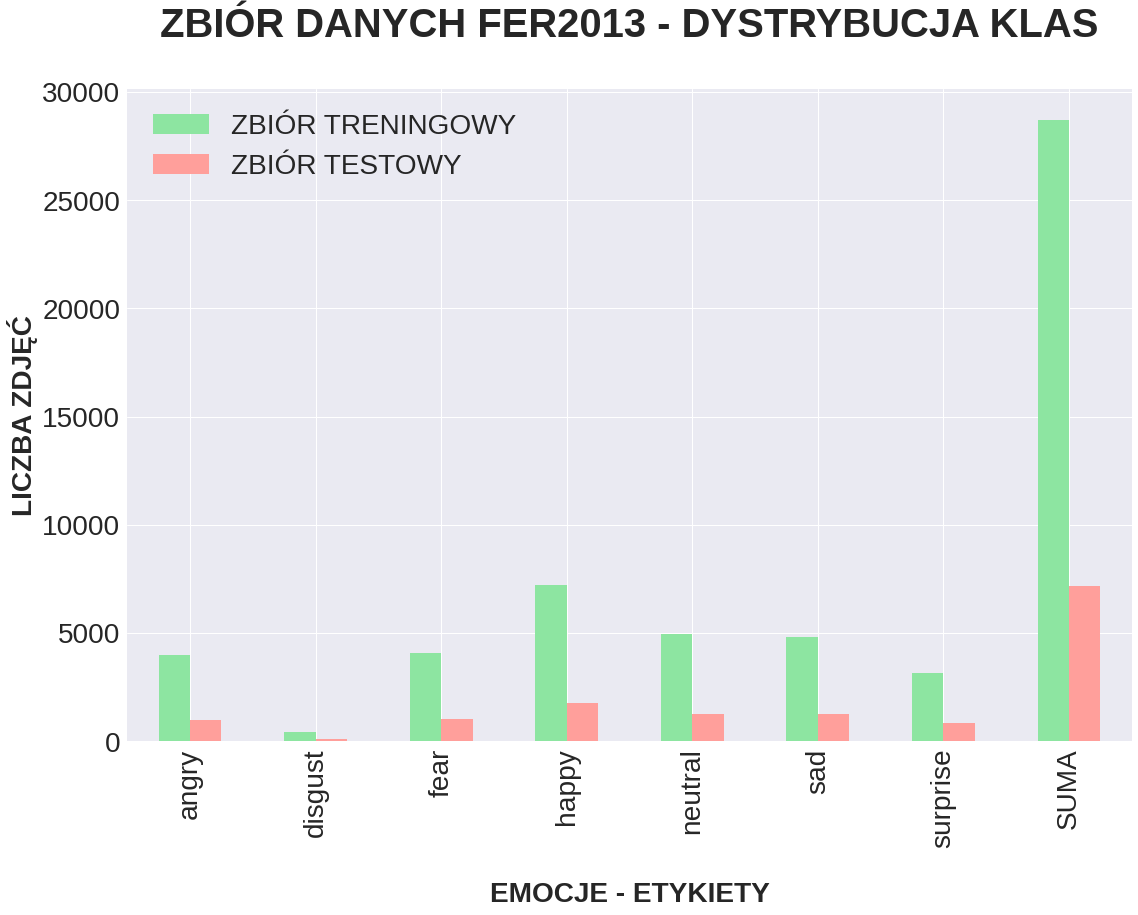

In [ ]:
colors = sns.color_palette("pastel")
fer_df.plot(
    x="nazwa etykiety", 
    y=["zbiór\ntreningowy", "zbiór\ntestowy"], 
    kind="bar", 
    figsize=(18,12), 
    color=colors[2:],
    fontsize=28,
)
plt.title('ZBIÓR DANYCH FER2013 - DYSTRYBUCJA KLAS\n', fontsize=40, fontweight='bold')
plt.xlabel("\nEMOCJE - ETYKIETY", fontsize=28, fontweight='bold')
plt.ylabel("LICZBA ZDJĘĆ", fontsize=28, fontweight='bold')
plt.legend(['ZBIÓR TRENINGOWY','ZBIÓR TESTOWY'],fontsize=28)
plt.style.use('seaborn-bright')

In [ ]:
width=48
height=48
labels_num = 7

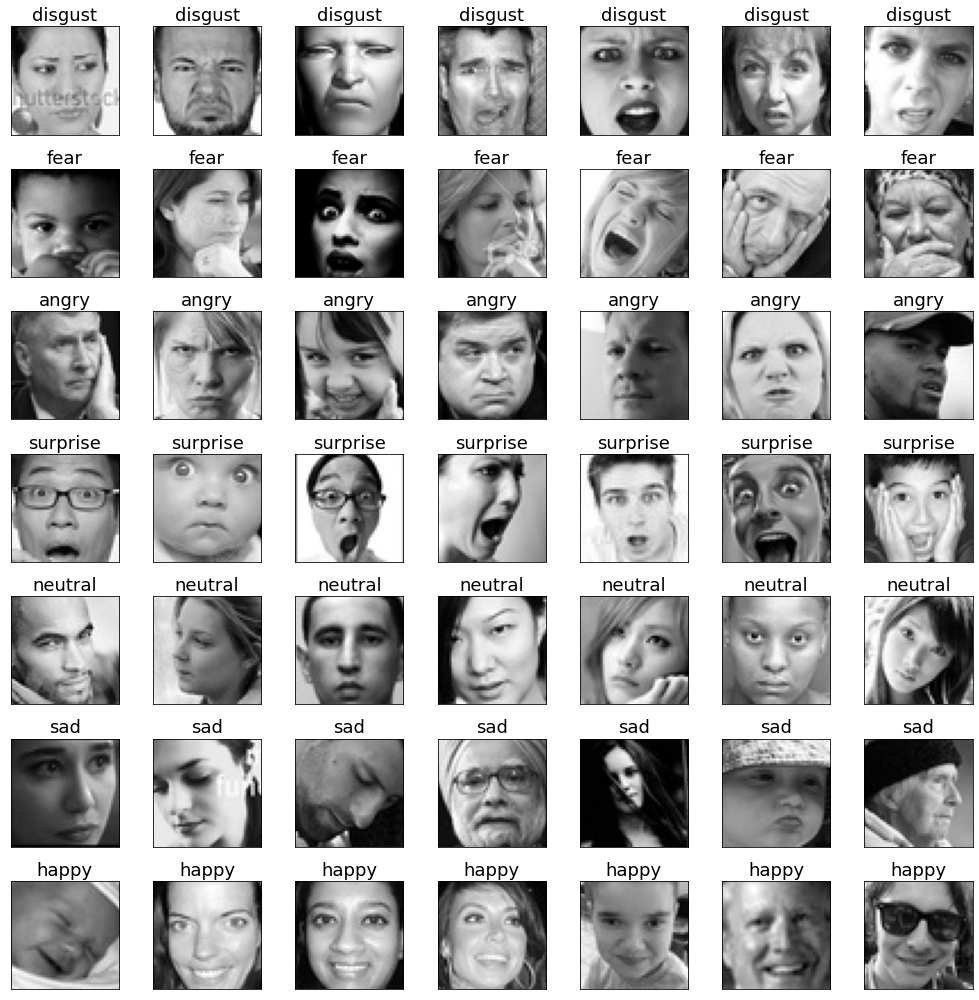

In [ ]:
img = plt.figure(1, (14, 14))
k = 0
for subfolder in train_folder:
  for i in range(7):
    imgs_paths = os.path.join(train_folder_path, subfolder, '*')
    img_path = glob.glob(imgs_paths)[k]
    img = io.imread(img_path)
    k += 1
    imgplt = plt.subplot(7, 7, k)
    imgplt.imshow(img, cmap='gray')
    imgplt.set_xticks([])
    imgplt.set_yticks([])
    imgplt.set_title(subfolder, fontsize=18)
plt.tight_layout()

# PRZETWARZANIE DANYCH

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
emotions_labels = train_generator.class_indices
print(emotions_labels)
emotions_labels = {key:value for value,key in emotions_labels.items()}
print(emotions_labels)
emotions_labels_list = [key for value, key in emotions_labels.items()]
print(emotions_labels_list)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


[0. 0. 0. 1. 0. 0. 0.] happy


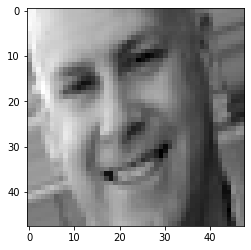

[0. 0. 0. 0. 1. 0. 0.] neutral


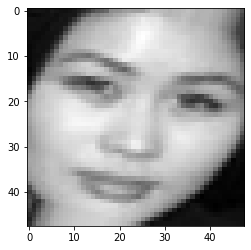

[0. 0. 0. 1. 0. 0. 0.] happy


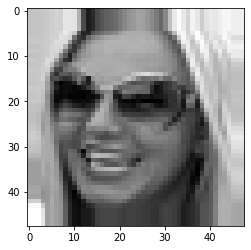

In [ ]:
x,y = train_generator.next()

x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print(label, [v for k, v in emotions_labels.items() if k==label.argmax()][0])
    plt.imshow(image[:,:,0], cmap="gray")
    plt.show()

In [ ]:
before_onethot_df = pd.DataFrame(data=[[key] for value,key in emotions_labels.items()], columns=['emotions'])
print('BEFORE ONE-HOT ENCODING:')
display(before_onethot_df)

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(before_onethot_df)

after_onehot_df = onehot_encoder.transform(before_onethot_df)
after_onehot_df = pd.DataFrame(data=after_onehot_df, columns=onehot_encoder.categories_)
print('\nAFTER ONE-HOT ENCODING:')
display(after_onehot_df)

BEFORE ONE-HOT ENCODING:


,emotions
0,angry
1,disgust
2,fear
3,happy
4,neutral
5,sad
6,surprise



AFTER ONE-HOT ENCODING:


,angry,disgust,fear,happy,neutral,sad,surprise
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
print(len(validation_generator[0][0])) #batch
print(len(validation_generator))
# print(len(validation_generator[0]))

128
57


#MODEL 1

In [ ]:
model_1 = Sequential([
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(labels_num, activation='softmax'),
])

model_1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 128)      

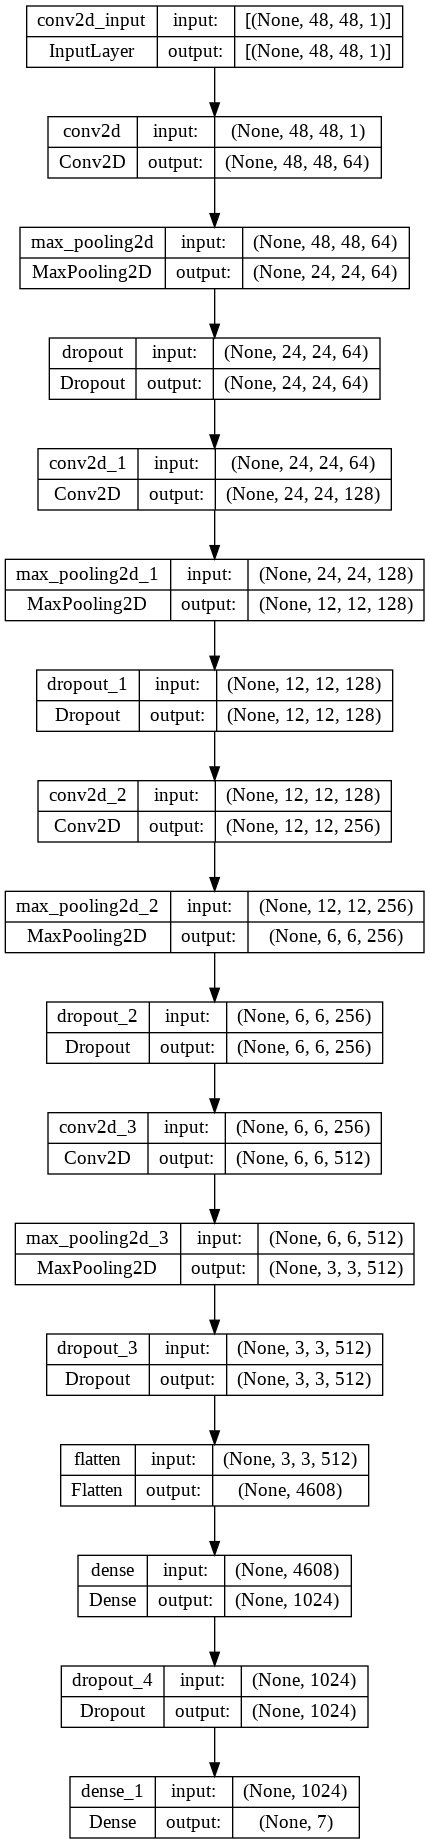

In [ ]:
plot_model(model_1, 'model_plot_1.png', show_shapes=True)

In [ ]:
steps = train_generator.n // train_generator.batch_size
valid_steps = validation_generator.n // validation_generator.batch_size
print(steps)
print(valid_steps)

224
56


In [ ]:
history_model_1 = model_1.fit(
        train_generator,
        steps_per_epoch=steps,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=valid_steps)

Epoch 1/30
224/224 [==============================] - 33s 88ms/step - loss: 1.8167 - accuracy: 0.2457 - val_loss: 1.7823 - val_accuracy: 0.2538
Epoch 2/30
224/224 [==============================] - 22s 97ms/step - loss: 1.7782 - accuracy: 0.2623 - val_loss: 1.7513 - val_accuracy: 0.2909
Epoch 3/30
224/224 [==============================] - 27s 120ms/step - loss: 1.7171 - accuracy: 0.3062 - val_loss: 1.6000 - val_accuracy: 0.3707
Epoch 4/30
224/224 [==============================] - 19s 86ms/step - loss: 1.6336 - accuracy: 0.3557 - val_loss: 1.4796 - val_accuracy: 0.4258
Epoch 5/30
224/224 [==============================] - 19s 85ms/step - loss: 1.5514 - accuracy: 0.3937 - val_loss: 1.4072 - val_accuracy: 0.4547
Epoch 6/30
224/224 [==============================] - 19s 86ms/step - loss: 1.4933 - accuracy: 0.4243 - val_loss: 1.3622 - val_accuracy: 0.4725
Epoch 7/30
224/224 [==============================] - 19s 86ms/step - loss: 1.4438 - accuracy: 0.4413 - val_loss: 1.3122 - val_accuracy

In [ ]:
model_1.save('./model_1.h5')
model_1_json = model_1.to_json()
with open('./model_1.json','w') as json_file:
  json_file.write(model_1_json)

# WYNIK MODEL 1

In [ ]:
model_1 = tf.keras.models.load_model('./model_1.h5')

In [ ]:
train_loss, train_accu = model_1.evaluate(train_generator)
test_loss, test_accu = model_1.evaluate(validation_generator)
print("TRAIN ACCURACY = {:.2f}\n TEST ACCURACY = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 2s 34ms/step - loss: 1.0670 - accuracy: 0.6000
TRAIN ACCURACY = 59.84
 TEST ACCURACY = 60.00


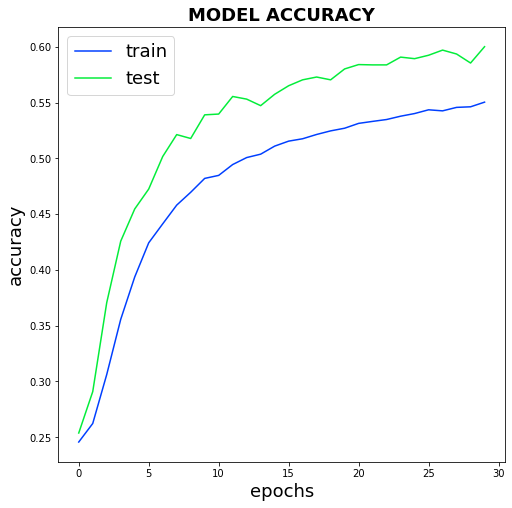

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('MODEL ACCURACY', fontsize=18, fontweight='bold')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(['train', 'test'], loc='upper left', fontsize=18)
plt.show()

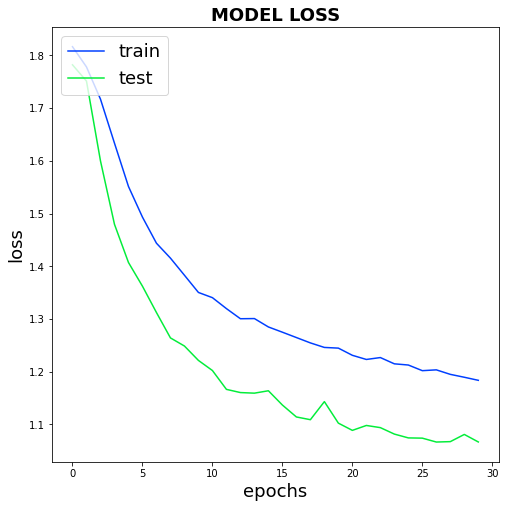

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('MODEL LOSS', fontsize=18, fontweight='bold')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend(['train', 'test'], loc='upper left', fontsize=18)
plt.show()

# MODEL 2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, 
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
emotions_labels = train_generator.class_indices
print(emotions_labels)
emotions_labels = {key:value for value,key in emotions_labels.items()}
print(emotions_labels)
emotions_labels_list = [key for value, key in emotions_labels.items()]
print(emotions_labels_list)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
model_2 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48,48,1)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(labels_num, activation='softmax'),
])

model_2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                    

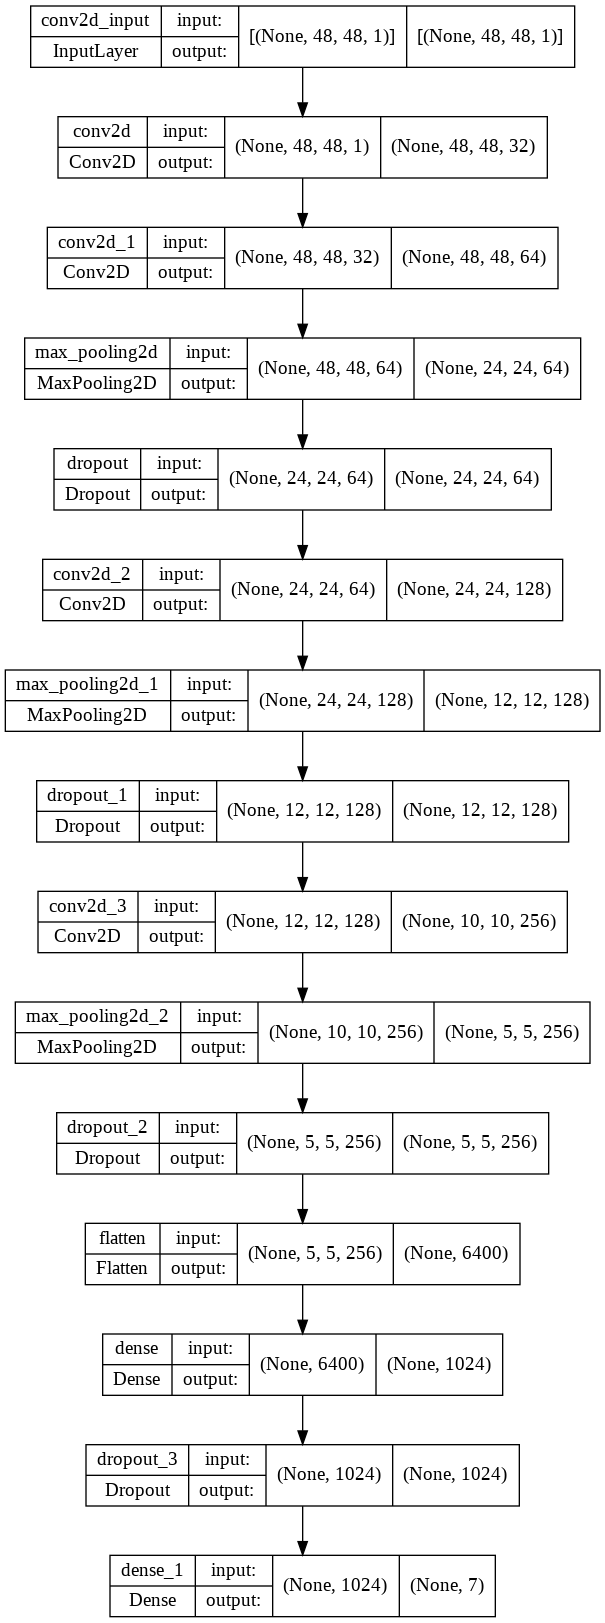

In [ ]:
plot_model(model_2, 'model_2_plot.png', show_shapes=True)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1) 
mc = ModelCheckpoint(filepath='./best_model_2.h5',
                             monitor='val_loss',
                             save_best_only=True)

In [ ]:
steps = train_generator.n // train_generator.batch_size
valid_steps = validation_generator.n // validation_generator.batch_size
print(steps)
print(valid_steps)

224
56


In [ ]:
history = model_2.fit(
        train_generator,
        steps_per_epoch=steps,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=valid_steps, 
        callbacks = [es, mc])

Epoch 1/100
224/224 [==============================] - 20s 91ms/step - loss: 1.7021 - accuracy: 0.3112 - val_loss: 1.5665 - val_accuracy: 0.3892
Epoch 2/100
224/224 [==============================] - 20s 88ms/step - loss: 1.5922 - accuracy: 0.3794 - val_loss: 1.4384 - val_accuracy: 0.4441
Epoch 3/100
224/224 [==============================] - 19s 87ms/step - loss: 1.4761 - accuracy: 0.4307 - val_loss: 1.3067 - val_accuracy: 0.4934
Epoch 4/100
224/224 [==============================] - 19s 86ms/step - loss: 1.4020 - accuracy: 0.4610 - val_loss: 1.2702 - val_accuracy: 0.5052
Epoch 5/100
224/224 [==============================] - 19s 86ms/step - loss: 1.3520 - accuracy: 0.4840 - val_loss: 1.2728 - val_accuracy: 0.5091
Epoch 6/100
224/224 [==============================] - 19s 86ms/step - loss: 1.3159 - accuracy: 0.4977 - val_loss: 1.2144 - val_accuracy: 0.5336
Epoch 7/100
224/224 [==============================] - 19s 86ms/step - loss: 1.2880 - accuracy: 0.5088 - val_loss: 1.1841 - val_ac

In [ ]:
model_2.save('./model_2.h5')
model_2_json = model_2.to_json()
with open('./model_2.json','w') as json_file:
  json_file.write(model_2_json)

# WYNIK MODEL 2 + WIZUALIZACJA

### ACCURACY + LOSS PLOT 

In [ ]:
model_2 = tf.keras.models.load_model('./best_model_2.h5')

In [ ]:
train_loss, train_accu = model_2.evaluate(train_generator)
test_loss, test_accu = model_2.evaluate(validation_generator)
print("FINAL TRAIN ACCURACY = {:.2f}\nFINAL VALIDATION ACCURACY = {:.2f}".format(train_accu*100, test_accu*100))

57/57 [==============================] - 2s 33ms/step - loss: 0.9509 - accuracy: 0.6556
FINAL TRAIN ACCURACY = 72.88
FINAL VALIDATION ACCURACY = 65.56


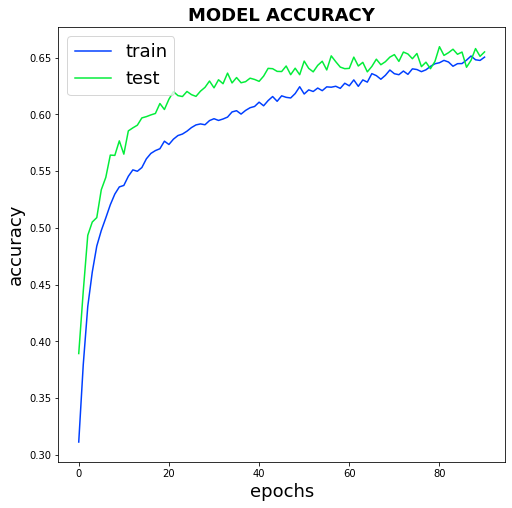

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MODEL ACCURACY', fontsize=18, fontweight='bold')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(['train', 'test'], loc='upper left', fontsize=18)
plt.show()

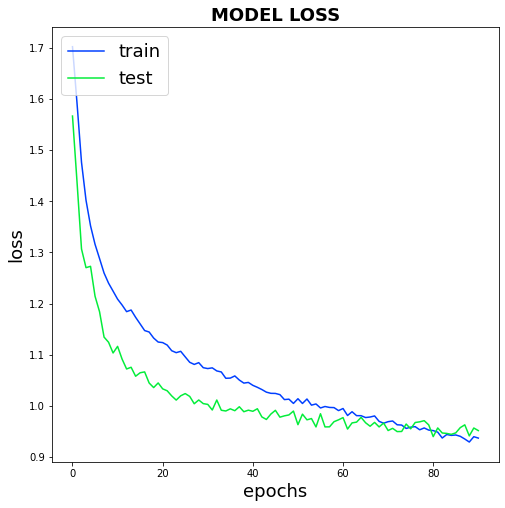

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS', fontsize=18, fontweight='bold')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend(['train', 'test'], loc='upper left', fontsize=18)
plt.show()

### CONFUSION MATRIX FOR TEST DATASET

In [ ]:
validation_generator.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
emotions_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

Confusion Matrix
[[ 559    6   56   44  121  149   23]
 [  41   41    5    5    0   16    3]
 [ 126    3  373   40  133  243  106]
 [  33    0   16 1577   81   36   31]
 [  54    0   43   88  826  204   18]
 [ 122    0   80   77  267  683   18]
 [  22    1   50   38   23   18  679]]

Raport klasyfikacji - - - - - - - - - - - - - - - - -

              precision    recall  f1-score   support

       angry       0.58      0.58      0.58       958
     disgust       0.80      0.37      0.51       111
        fear       0.60      0.36      0.45      1024
       happy       0.84      0.89      0.87      1774
     neutral       0.57      0.67      0.62      1233
         sad       0.51      0.55      0.53      1247
    surprise       0.77      0.82      0.79       831

    accuracy                           0.66      7178
   macro avg       0.67      0.61      0.62      7178
weighted avg       0.66      0.66      0.65      7178



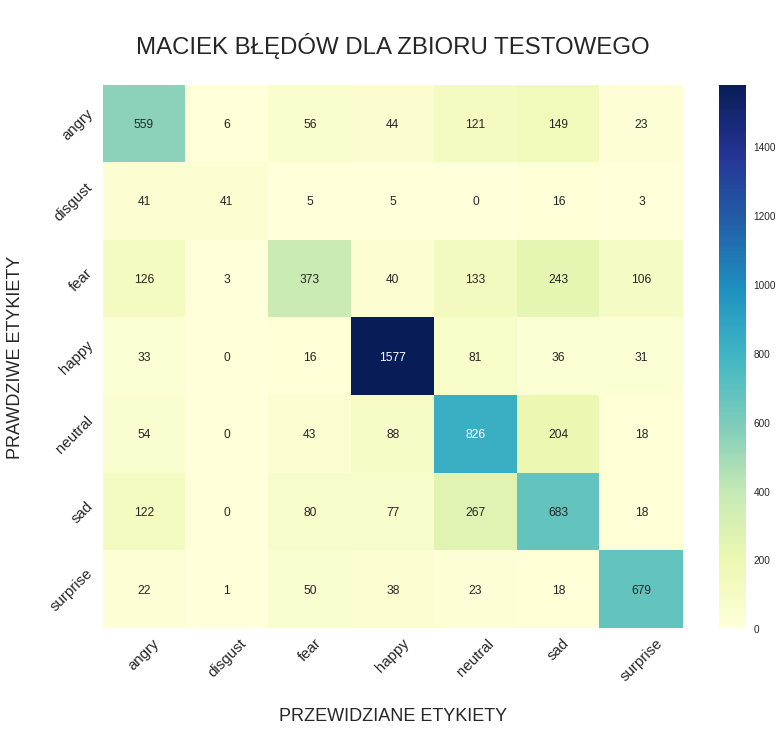

In [ ]:
#ON TESTING SET
y_pred = model_2.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('\nRaport klasyfikacji - - - - - - - - - - - - - - - - -\n')
print(classification_report(validation_generator.classes, y_pred, target_names=emotions_labels_list))

plt.figure(figsize=(13,10))
ax = sns.heatmap(cm_test, annot=True, annot_kws={"size": 12}, fmt="d", cmap="YlGnBu")
ax.set_xticklabels(emotions_labels_list, size = 15, rotation=45)
ax.set_yticklabels(emotions_labels_list, size = 15, rotation=45)

plt.ylabel('PRAWDZIWE ETYKIETY\n', fontsize=18)
plt.xlabel('\nPRZEWIDZIANE ETYKIETY', fontsize=18)
plt.title('\nMACIEK BŁĘDÓW DLA ZBIORU TESTOWEGO\n', fontsize=24)
plt.show()

### PLOT FOR 49 IMAGES FOR RANDOM BATCH



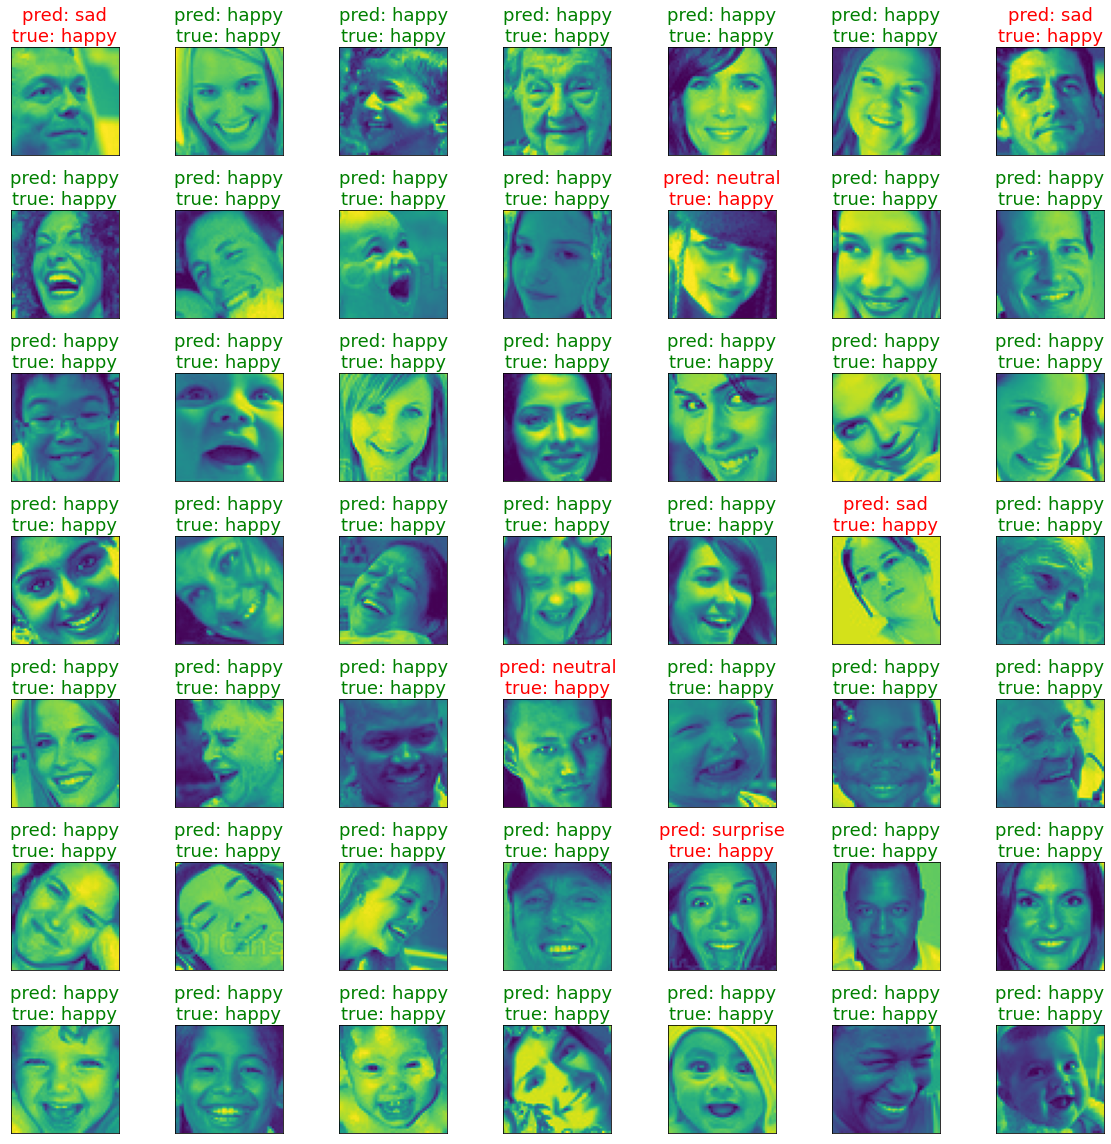

In [ ]:
figure = plt.figure(1, (16, 16))
k= 0 
for i, id in enumerate(np.random.choice(x_test.shape[0], size=49, replace=False)):
  k+=1
  predplt = plt.subplot(7, 7, k)
  predplt.imshow(np.squeeze(x_test[id]))
  predplt.set_xticks([])
  predplt.set_yticks([])
  pred_id = emotions_labels[(predictions[id])]
  true_id = emotions_labels[(test_labels[id])]
  
  predplt.set_title("pred: {}\ntrue: {}".format((pred_id), 
                                (true_id)),
                                color=("green" if pred_id == true_id else "red"), fontsize=18)
  plt.subplots_adjust(hspace = 0.7)
plt.tight_layout()

### RANDOM IMG GENERATOR WITH PREDICTIONS

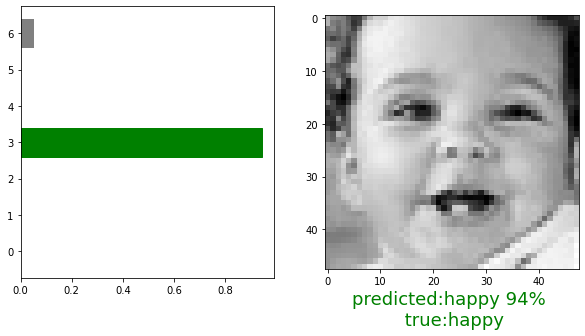

None


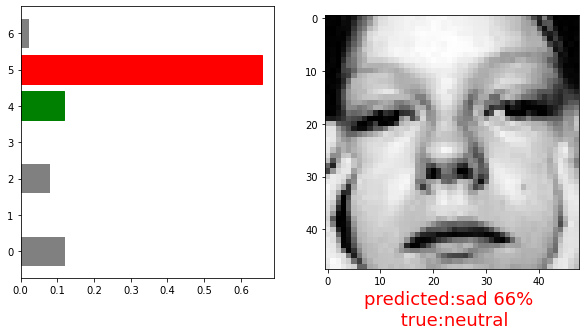

None


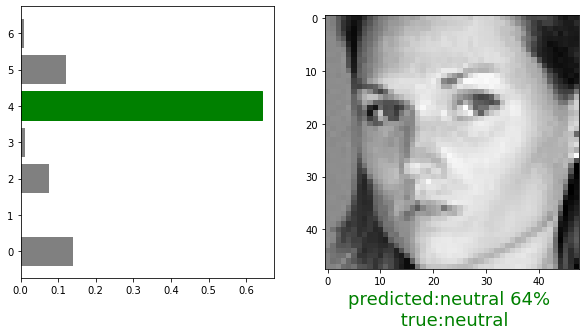

None


In [ ]:
def plot_value_img(i, valid):
    x_test, y_test = valid
    y_val_pred = model_2.predict(x_test)
    y_val_pred, y_test, x_test = y_val_pred[i], y_test[i], x_test[i]    
    predicted_label = np.argmax(y_val_pred)
    true_value = np.argmax(y_test)   
     
    plt.figure(figsize=(10,5))
     
    plt.subplot(1, 2, 1)
    plt.yticks(np.arange(len(emotions_labels)), emotions_labels)
    thisplot = plt.barh(range(labels_num), y_val_pred, color="gray") 
    thisplot[predicted_label].set_color('r')
    thisplot[true_value].set_color('g')
 
    plt.subplot(1, 2, 2) 
     
    plt.imshow(x_test[:,:,0], cmap="gray")
    if predicted_label == true_value:
        color = 'green'
    else:
        color = 'red'
 
    plt.xlabel("predicted:{} {:2.0f}% \n true:{}".format(emotions_labels[predicted_label],
                                100*np.max(y_val_pred),
                                emotions_labels[true_value]),
                                color=color, fontsize=18)    
    plt.show()
     
print(plot_value_img(0, validation_generator.next()))
print(plot_value_img(1, validation_generator.next()))
print(plot_value_img(127, validation_generator.next()))